# A Jupyter Notebook to Perform Pricing Using the Bates Formula
This notebook demonstrates the implementation of the Bates formula for pricing Bonus Certificates. It includes steps for importing libraries, defining the formula, setting parameters, simulating asset price paths, calculating option prices, and visualizing results.

## Import Required Libraries
Import necessary libraries such as NumPy, SciPy, and Matplotlib for numerical computations and visualizations.

In [1]:
import sys
import os
sys.path.append(os.path.abspath('..'))  # Adds the parent directory to the Python path

In [2]:
# data
S0 = 77.56
B = 85
L = 65
H = 55
q = 0.02
T = 437/365 # 08/04/25 - 16/06/26

In [3]:
# Import Required Libraries
from src.payout.payout import calculate_bonus_certificate_payout, plot_payout

In [4]:
plot_payout(B, H, S0)

## Calculate interest rate
Obtain interest rate from forward prices of the vanilla market prices

In [5]:
from src.interest_rates.calculate_interest_rates import calculate_interest_rate_from_parity, plot_interest_rates
import pandas as pd

In [6]:
# Load the CSV file into a pandas DataFrame
file_path = "../data/data.csv"  # Adjust the path if necessary
df = pd.read_csv(file_path)
df['Spot'] = S0
df = df[['Bid_Call', 'Ask_Call', 'Bid_Put', 'Ask_Put', 'Spot', 'Strike', 'IV_Put', 'IV_Call']]

# Display the first few rows of the DataFrame
print(df.head())

   Bid_Call  Ask_Call  Bid_Put  Ask_Put   Spot  Strike  IV_Put  IV_Call
0      37.0      41.5     0.00      3.3  77.56    40.0   0.502    0.502
1      34.5      39.0     0.00      3.6  77.56    42.5   0.481    0.481
2      32.5      37.0     0.00      3.8  77.56    45.0   0.466    0.466
3      30.5      35.0     0.85      4.1  77.56    47.5   0.445    0.445
4      28.0      32.5     0.55      4.2  77.56    50.0   0.430    0.430


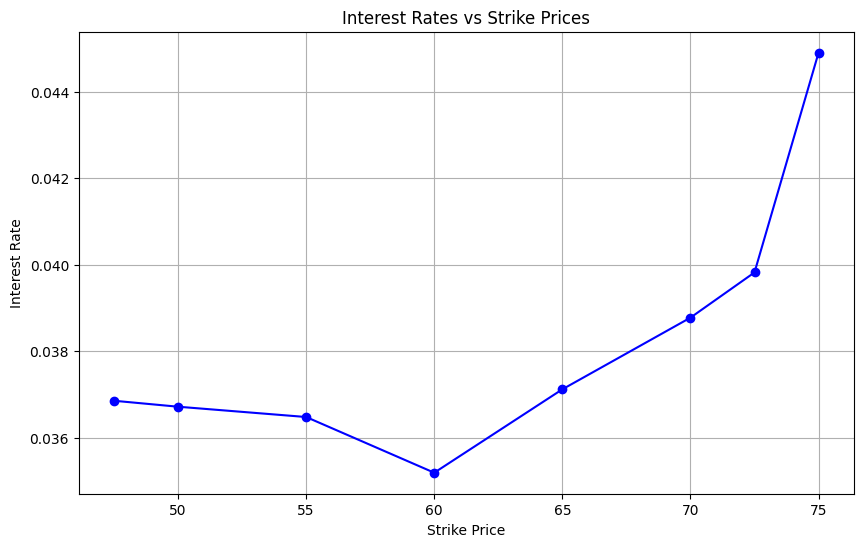

0.0382282877288231


In [7]:
# Calculate interest rates from parity
interest_rates = calculate_interest_rate_from_parity(df, q, T)
# print (interest_rates.head())

# Display the calculated interest rates
plot_interest_rates(interest_rates)

r = interest_rates['InterestRate'].mean()
print(r)

In [8]:
# Store the mean interest rate in a variable
mean_interest_rate = interest_rates['InterestRate'].mean()
print(f'Mean Interest Rate: {mean_interest_rate}')

Mean Interest Rate: 0.0382282877288231


## Calculate volatility skew
Plot IV versus strike, note call are underpriced due to dividends and market crash after "liberation" day

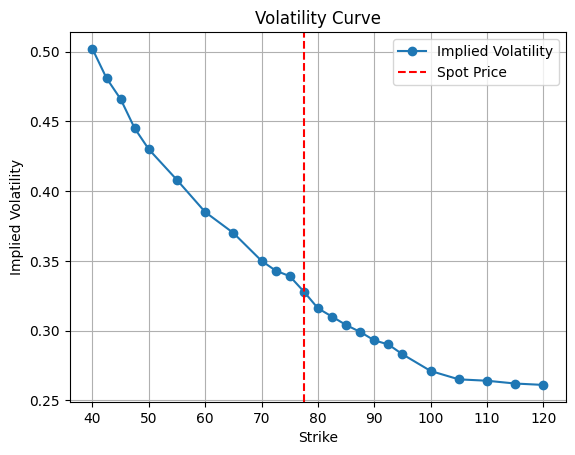

In [9]:
import matplotlib.pyplot as plt

# Add a new column for implied volatility based on the condition
df['ImpliedVolatility'] = df.apply(
    lambda row: row['IV_Put'] if row['Strike'] < S0 else row['IV_Call'], axis=1
)

# Plot the implied volatility curve
plt.plot(df['Strike'], df['ImpliedVolatility'], 'o-', label='Implied Volatility')
plt.xlabel("Strike")
plt.ylabel("Implied Volatility")
plt.title("Volatility Curve")
plt.axvline(x=S0, color='red', linestyle='--', label='Spot Price')
plt.grid(True)
plt.legend()
plt.show()

## Calibrate Bates Model
Use the Bates model to calibrate on market prices and minimize the sum of squared errors.

In [10]:
from src.bates_formula.calibration import calibrate_bates_model

# Extract market prices and strikes
market_prices = (df['Bid_Call'] + df['Ask_Call']) / 2  # Mid prices for calls
strikes = df['Strike']

# Use the mean interest rate in Bates model calibration
calibrated_params = calibrate_bates_model(market_prices, strikes, S0, T, mean_interest_rate, q)
print("Calibrated Bates Model Parameters:", calibrated_params)

Calibrated Bates Model Parameters: {'V0': np.float64(0.1590455361140341), 'kappa': np.float64(0.4615881495411213), 'eta': np.float64(0.032918042914123646), 'theta': np.float64(0.5), 'rho': np.float64(-0.7303829675747497), 'jump_intensity': np.float64(0.11534040868811937), 'jump_mean': np.float64(-0.21850927140512102), 'jump_stddev': np.float64(0.1694311020866451)}


## Plot Bates Model Prices vs Market Prices
Visualize the calibrated Bates model prices against the actual market prices.

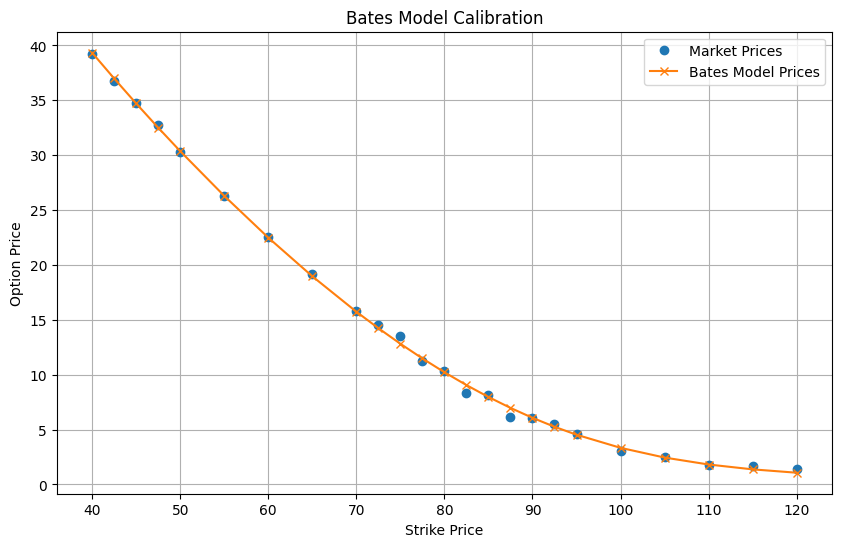

In [11]:
# Generate Bates model prices
from src.bates_formula.bates_model import BatesModel

bates = BatesModel(S0, r, q, calibrated_params['V0'], calibrated_params['kappa'], calibrated_params['eta'], calibrated_params['theta'], calibrated_params['rho'], T, strikes=strikes,
                   jump_intensity=calibrated_params['jump_intensity'], jump_mean=calibrated_params['jump_mean'], jump_stddev=calibrated_params['jump_stddev'])
bates_prices = bates.price_options()

# Plot market prices vs Bates model prices
plt.figure(figsize=(10, 6))
plt.plot(strikes, market_prices, 'o', label='Market Prices')
plt.plot(strikes, bates_prices, 'x-', label='Bates Model Prices')
plt.xlabel('Strike Price')
plt.ylabel('Option Price')
plt.title('Bates Model Calibration')
plt.legend()
plt.grid(True)
plt.show()

## Calibrate Bates Model for All Maturities
Use the BatesModelCalibrator class to find the best parameters for all maturities.

## Calibrate Bates Model Globally
Use the BatesModelGlobalCalibrator class to find the best parameters for all maturities combined.

In [12]:
from src.data_processing.market_data_processor import MarketDataProcessor

# Initialize the MarketDataProcessor
data_folder = '../data/marketDataClose25-04'
processor = MarketDataProcessor(data_folder)
processor.load_and_process_data()

# Retrieve the list of DataFrames
dataframes_list = processor.get_dataframes_list()

# Print the head of each DataFrame by maturity
for maturity, df in processor.data_by_maturity.items():
    print(f'--- Maturity: {maturity} ---')
    print(df.head())

--- Maturity: 01/01/2026 ---
  BS_Call  Last_Call  Bid_Call  Ask_Call  Change_Call  Delta_Call  IV_Call  \
0      BS      42.66      49.4      54.0          0.0       0.995    0.490   
1      BS       0.00      44.5      48.4          0.0       0.991    0.485   
2      BS       0.00      42.1      46.0          0.0       0.986    0.478   
3      BS      33.60      39.7      43.6          0.0       0.971    0.457   
4      BS       0.00      37.2      41.4          0.0       0.964    0.444   

   Vol_Call OpenInt_Call  Strike  Last_Put  Bid_Put  Ask_Put  Change_Put  \
0         0            0    30.0      0.25     0.10     2.25         0.0   
1         0            0    35.0      0.45     0.00     1.45         0.0   
2         0            0    37.5      0.50     0.00     1.50         0.0   
3         0           11    40.0      0.27     0.10     0.50         0.0   
4         0            0    42.5      0.90     0.15     1.20         0.0   

   Delta_Put  IV_Put  Vol_Put OpenInt_Put BS_

In [13]:
from src.bates_formula.calibration_global import BatesModelGlobalCalibrator

# Perform global calibration
S0 = 81.25  # Spot price
r = 0.04    # Risk-free rate
q = 0.02    # Dividend yield
data_folder = '../data/marketDataClose25-04'

#global_calibrator = BatesModelGlobalCalibrator(data_folder, S0, r, q)
#global_calibrator.calibrate_global_model()

# Retrieve and print the global calibrated parameters
#global_params = global_calibrator.get_global_calibrated_params()
#print('Global Calibrated Parameters:', global_params)

In [ ]:
import numpy as np

global_params = {
    'V0': np.float64(0.03314133662402323),
    'kappa': np.float64(2.0),
    'eta': np.float64(0.06797967406717075),
    'theta': np.float64(0.14987718209558357),
    'rho': np.float64(-0.99),
    'jump_intensity': np.float64(0.01),
    'jump_mean': np.float64(0.01),
    'jump_stddev': np.float64(0.01)
}

In [15]:
print(global_params)

{'V0': 0.03314133662402323, 'kappa': 2.0, 'eta': 0.06797967406717075, 'theta': 0.14987718209558357, 'rho': -0.99, 'jump_intensity': 0.01, 'jump_mean': 0.01, 'jump_stddev': 0.01}


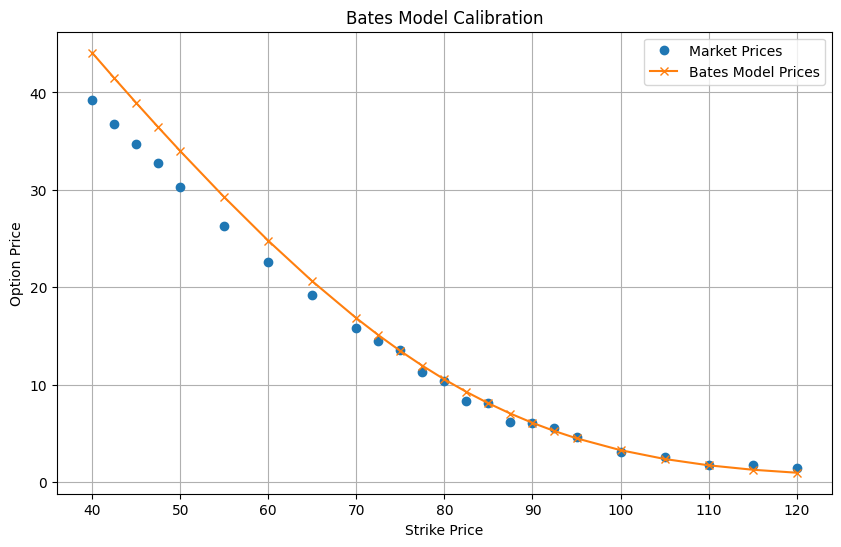

In [16]:
# Generate Bates model prices

bates = BatesModel(S0, r, q, global_params['V0'], global_params['kappa'], global_params['eta'], global_params['theta'], global_params['rho'], T, strikes=strikes,
                   jump_intensity=global_params['jump_intensity'], jump_mean=global_params['jump_mean'], jump_stddev=global_params['jump_stddev'])
bates_prices = bates.price_options()

# Plot market prices vs Bates model prices
plt.figure(figsize=(10, 6))
plt.plot(strikes, market_prices, 'o', label='Market Prices')
plt.plot(strikes, bates_prices, 'x-', label='Bates Model Prices')
plt.xlabel('Strike Price')
plt.ylabel('Option Price')
plt.title('Bates Model Calibration')
plt.legend()
plt.grid(True)
plt.show()

TypeError: can't multiply sequence by non-int of type 'float'

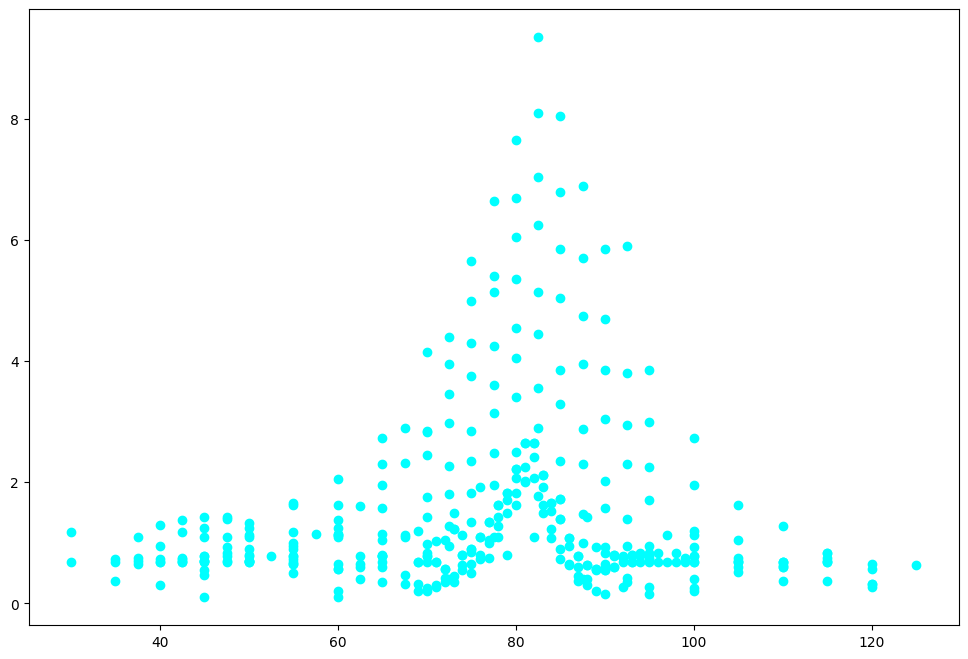

In [21]:
import matplotlib.pyplot as plt

# Use MarketDataProcessor to load and process data
data_folder = '../data/marketDataClose25-04'
processor = MarketDataProcessor(data_folder)
processor.load_and_process_data()
combined_data = pd.concat(processor.get_dataframes_list(), ignore_index=True)

# Filter in-the-money options
S0 = 81.25
out_of_money_calls = combined_data.loc[combined_data['Strike'] > S0].copy()
out_of_money_puts = combined_data.loc[combined_data['Strike'] < S0].copy()

# Calculate mid prices for calls and puts
out_of_money_calls['Mid_Call'] = (out_of_money_calls['Bid_Call'] + out_of_money_calls['Ask_Call']) / 2
out_of_money_puts['Mid_Put'] = (out_of_money_puts['Bid_Put'] + out_of_money_puts['Ask_Put']) / 2

plt.figure(figsize=(12, 8))

# Plot mid prices for calls
plt.plot(out_of_money_calls['Strike'], out_of_money_calls['Mid_Call'], 'o', color='cyan', label='Mid Call (Strike > S0)')

# Plot mid prices for puts
plt.plot(out_of_money_puts['Strike'], out_of_money_puts['Mid_Put'], 'o', color='cyan', label='Mid Put (Strike < S0)')

# Loop over maturities in your data and generate Bates model prices
for maturity, df in processor.data_by_maturity.items():
    strikes_maturity = df['Strike'].values.astype(float)  # Ensure strikes are float for each maturity
    
    # Instantiate Bates model for each maturity
    bates_maturity = BatesModel(
        S0, r, q,
        global_params['V0'], global_params['kappa'], global_params['eta'], global_params['theta'], global_params['rho'],
        T=maturity,  # Use the current maturity
        strikes=strikes_maturity,
        jump_intensity=global_params['jump_intensity'],
        jump_mean=global_params['jump_mean'],
        jump_stddev=global_params['jump_stddev']
    )
    
    # Get Bates model prices for this maturity
    bates_prices = bates_maturity.price_options()

    # Plot Bates model prices
    plt.plot(strikes_maturity, bates_prices, 'x-', label=f'Bates Model Prices ({maturity:.2f} years)')


# Display current price on the chart
plt.axvline(x=S0, color='red', linestyle='--', label=f'Current Price: {S0}')

plt.xlabel('Strike Price')
plt.ylabel('Mid Price')
plt.title('Mid Prices for Out-of-the-Money Options vs Bates Model')
plt.legend(title='Legend', bbox_to_anchor=(1.05, 1), loc='upper left', fancybox=True, shadow=True)
plt.grid(True)
plt.show()


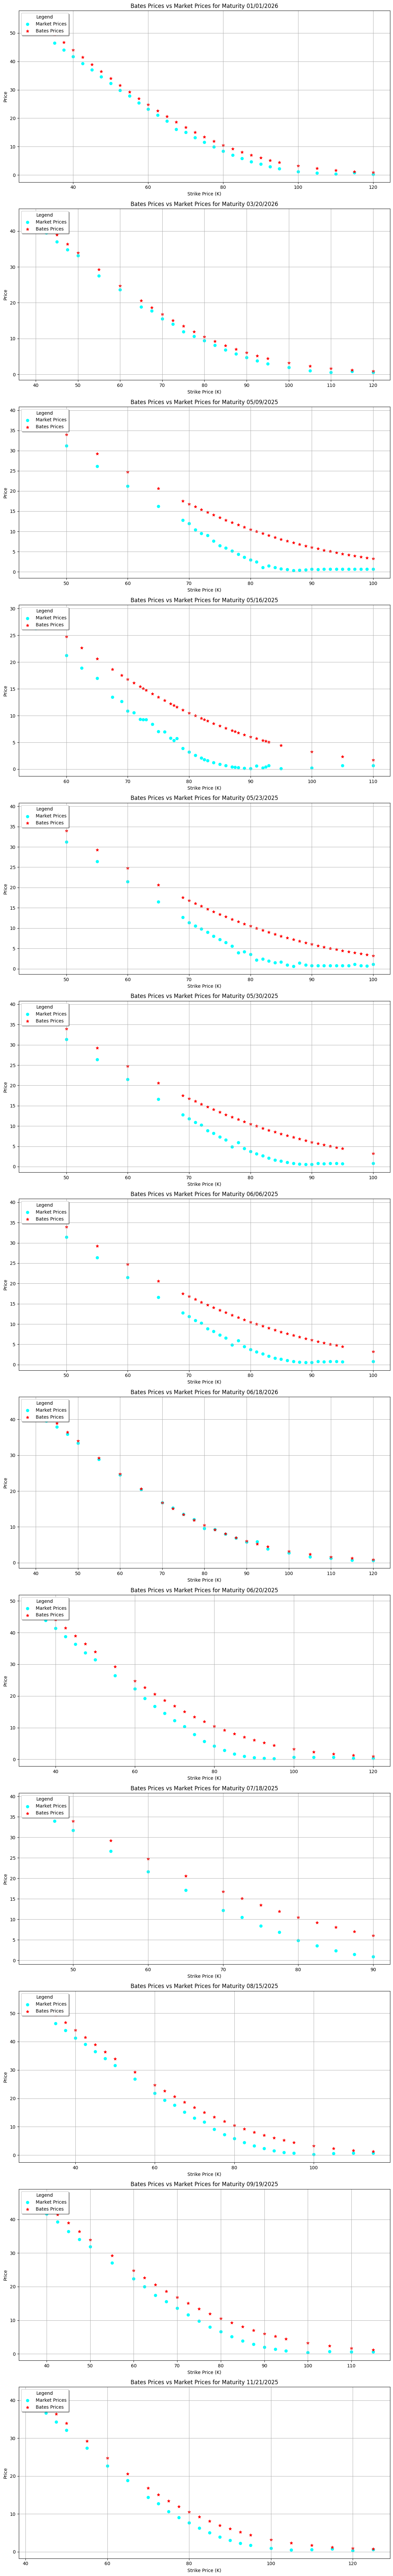

In [ ]:
# Create a single figure with subplots for all maturities
num_maturities = len(processor.data_by_maturity)
fig, axes = plt.subplots(num_maturities, 1, figsize=(12, 6 * num_maturities))

# Iterate over each maturity and plot the Bates price for each strike
for ax, (maturity, df) in zip(axes, processor.data_by_maturity.items()):
    strikes = df['Strike']
    mid_prices = (df['Bid_Call'] + df['Ask_Call']) / 2

    # Calculate Bates prices for each strike
    bates_prices = BatesModel(S0, r, q, global_params['V0'], global_params['kappa'], global_params['eta'], global_params['theta'], global_params['rho'], T, strikes=strikes,
                            jump_intensity=global_params['jump_intensity'], jump_mean=global_params['jump_mean'], jump_stddev=global_params['jump_stddev']).price_options()

    # Plot mid prices
    ax.scatter(strikes, mid_prices, label='Market Prices', color='cyan', marker='o')

    # Plot Bates prices with small red stars
    ax.scatter(strikes, bates_prices, label='Bates Prices', color='red', marker='*')

    # Add labels and title
    ax.set_xlabel('Strike Price (K)')
    ax.set_ylabel('Price')
    ax.set_title(f'Bates Prices vs Market Prices for Maturity {maturity}')
    ax.legend(title='Legend', loc='upper left', fancybox=True, shadow=True)
    ax.grid(True)

# Adjust layout
plt.tight_layout()
plt.show()